<a href="https://colab.research.google.com/github/dema-u/keras_triplet_descriptor/blob/master/DLCW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Check GPU, load and allocate the data.

In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  
printm()

!git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor
  
%cd /content/keras_triplet_descriptor  

!wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
  
!unzip -q ./hpatches_data.zip
!rm ./hpatches_data.zip



import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate  

from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs)) 


  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
('RAM Free: 12.9 GB', ' | Proc size: 151.4 MB')
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB
Cloning into 'keras_triplet_descriptor'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 178 (delta 25), reused 22 (delta 10), pack-reused 128
Receiving objects: 100% (178/178), 149.84 MiB | 20.14 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Checking out files: 100% (69/69), done.
/content/keras_triplet_descriptor
--2019-02-22 20:12:32--  https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 107.152.25.197, 107.152.24.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|107.152.25.197|:443... connected.
HTT

Using TensorFlow backend.


Defining our models and loss.

In [0]:
def get_denoise_model(shape):
    
  inputs = Input(shape)
  
  ## Encoder starts
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  
  ## Bottleneck
  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)

  ## Now the decoder starts
  up3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
  merge3 = concatenate([conv1,up3], axis = -1)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
    
  conv4 = Conv2D(1, 3,  padding = 'same')(conv3)

  shallow_net = Model(inputs = inputs, outputs = conv4)
  
  return shallow_net

def get_descriptor_model(shape):
  
  '''Architecture copies HardNet architecture'''
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.3))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  
  # Final descriptor reshape
  descriptor_model.add(Reshape((128,)))
  
  return descriptor_model

def triplet_loss(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

Setup the denoise data.

In [4]:
denoise_generator = DenoiseHPatches(seqs_train, batch_size=50)
denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

shape = (32, 32, 1)
denoise_model = get_denoise_model(shape)

100%|██████████| 40/40 [00:42<00:00,  1.28s/it]


Instructions for updating:
Colocations handled automatically by placer.


Train the denoise model.

In [5]:
sgd = keras.optimizers.SGD(lr=0.00001, momentum=0.9, nesterov=True)
denoise_model.compile(loss='mean_absolute_error', optimizer=sgd, metrics=['mae'])
###del denoise_history
### Use a loop to save for each epoch the weights in an external website in
### case colab stops. Every time you call fit/fit_generator the weigths are NOT
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)

denoise_history = denoise_model.fit_generator(generator=denoise_generator, epochs=3, verbose=1, validation_data=denoise_generator_val)

  ### Saves optimizer and weights
  ###denoise_model.save('denoise.h5') 
  ### Uploads files to external hosting
  ###!curl -F "file=@denoise.h5" https://file.io

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
31179/31179 [==============================] - 861s 28ms/step - loss: 6.6790 - mean_absolute_error: 6.6790 - val_loss: 6.1277 - val_mean_absolute_error: 6.1277
Epoch 2/3
31179/31179 [==============================] - 857s 27ms/step - loss: 6.1071 - mean_absolute_error: 6.1071 - val_loss: 5.8516 - val_mean_absolute_error: 5.8516
Epoch 3/3
31179/31179 [==============================] - 860s 28ms/step - loss: 5.9780 - mean_absolute_error: 5.9780 - val_loss: 5.7985 - val_mean_absolute_error: 5.7985


De-noising model *training* curves.

Text(0.5,0,'Epoch')

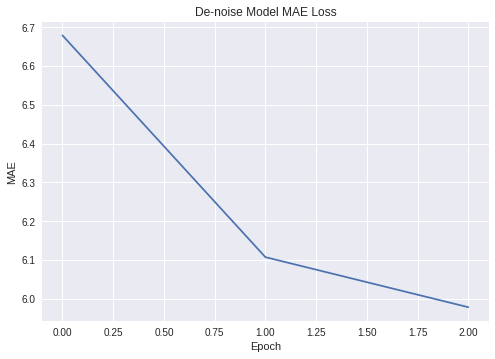

In [6]:
import matplotlib.pyplot as plt

plt.plot(denoise_history.history['mean_absolute_error'])
plt.title('De-noise Model MAE Loss')
plt.ylabel('MAE')
plt.xlabel('Epoch')

If we want to save the the de-noise model.

In [0]:
denoise_model.save('denoise.h5')

from google.colab import files
files.download('denoise.h5')

Denoising the data from before.

In [8]:
### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model, use_clean=False)
# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=10000)

Using denoised patches
100%|██████████| 116/116 [00:36<00:00,  3.15it/s]
Denoising patches...
100%|██████████| 15589/15589 [04:08<00:00, 62.66it/s]


100%|██████████| 100000/100000 [00:01<00:00, 66319.42it/s]


Using denoised patches
100%|██████████| 116/116 [00:21<00:00,  1.86it/s]
Denoising patches...
100%|██████████| 9525/9525 [02:32<00:00, 62.55it/s]


100%|██████████| 10000/10000 [00:00<00:00, 61243.41it/s]


Defining the triplet model and training it.

In [9]:
from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)
sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

descriptor_history = descriptor_model_trip.fit_generator(generator=training_generator, epochs=10, verbose=1, validation_data=val_generator)

descriptor_model_trip.save('descriptor.h5') 

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/10
1999/2000 [============================>.] - ETA: 0s - loss: 0.2193

100%|██████████| 100000/100000 [00:04<00:00, 23978.00it/s]


2000/2000 [==============================] - 162s 81ms/step - loss: 0.2193 - val_loss: 0.2410
Epoch 2/10
  10/2000 [..............................] - ETA: 4:06 - loss: 0.1490

  0%|          | 0/10000 [00:00<?, ?it/s]

  11/2000 [..............................] - ETA: 3:58 - loss: 0.1478

 35%|███▍      | 3482/10000 [00:00<00:00, 34811.65it/s]

  13/2000 [..............................] - ETA: 3:46 - loss: 0.1546

 72%|███████▏  | 7180/10000 [00:00<00:00, 35405.67it/s]

  14/2000 [..............................] - ETA: 3:40 - loss: 0.1519

100%|██████████| 10000/10000 [00:00<00:00, 31094.23it/s]

  15/2000 [..............................] - ETA: 3:39 - loss: 0.1518

1999/2000 [============================>.] - ETA: 0s - loss: 0.1601

 89%|████████▉ | 88991/100000 [00:03<00:00, 30753.59it/s]

2000/2000 [==============================] - 160s 80ms/step - loss: 0.1601 - val_loss: 0.2176


 93%|█████████▎| 93217/100000 [00:03<00:00, 30462.03it/s]

Epoch 3/10


100%|██████████| 100000/100000 [00:04<00:00, 23695.00it/s]


   5/2000 [..............................] - ETA: 8:20 - loss: 0.1484

  0%|          | 0/10000 [00:00<?, ?it/s]

   6/2000 [..............................] - ETA: 7:24 - loss: 0.1676

 19%|█▉        | 1889/10000 [00:00<00:01, 4375.56it/s]

   8/2000 [..............................] - ETA: 7:35 - loss: 0.1626

 55%|█████▍    | 5479/10000 [00:00<00:00, 5940.47it/s]

   9/2000 [..............................] - ETA: 7:03 - loss: 0.1719

100%|██████████| 10000/10000 [00:00<00:00, 14628.71it/s]

  10/2000 [..............................] - ETA: 6:42 - loss: 0.1674

1999/2000 [============================>.] - ETA: 0s - loss: 0.1476

 82%|████████▏ | 81693/100000 [00:03<00:00, 31305.00it/s]

2000/2000 [==============================] - 161s 80ms/step - loss: 0.1477 - val_loss: 0.1813


 86%|████████▌ | 86178/100000 [00:03<00:00, 34407.63it/s]

Epoch 4/10


100%|██████████| 100000/100000 [00:04<00:00, 21897.40it/s]


   3/2000 [..............................] - ETA: 16:25 - loss: 0.1104

  0%|          | 0/10000 [00:00<?, ?it/s]

   4/2000 [..............................] - ETA: 12:55 - loss: 0.1194

 33%|███▎      | 3299/10000 [00:00<00:00, 32988.69it/s]

   6/2000 [..............................] - ETA: 9:31 - loss: 0.1305 

 66%|██████▌   | 6615/10000 [00:00<00:00, 33035.25it/s]

   7/2000 [..............................] - ETA: 8:33 - loss: 0.1260

100%|██████████| 10000/10000 [00:00<00:00, 30620.74it/s]

   8/2000 [..............................] - ETA: 7:52 - loss: 0.1300

1999/2000 [============================>.] - ETA: 0s - loss: 0.1329

 89%|████████▉ | 89263/100000 [00:03<00:00, 29422.46it/s]

2000/2000 [==============================] - 161s 81ms/step - loss: 0.1329 - val_loss: 0.1536


 93%|█████████▎| 93105/100000 [00:03<00:00, 31629.14it/s]

Epoch 5/10


100%|██████████| 100000/100000 [00:04<00:00, 23342.01it/s]


   5/2000 [..............................] - ETA: 8:23 - loss: 0.0910

  0%|          | 0/10000 [00:00<?, ?it/s]

   6/2000 [..............................] - ETA: 7:24 - loss: 0.0846

 41%|████▏     | 4147/10000 [00:00<00:00, 40831.42it/s]

   8/2000 [..............................] - ETA: 6:12 - loss: 0.0849

 69%|██████▉   | 6894/10000 [00:00<00:00, 35624.08it/s]

   9/2000 [..............................] - ETA: 5:48 - loss: 0.0949

100%|██████████| 10000/10000 [00:00<00:00, 30611.00it/s]

  10/2000 [..............................] - ETA: 5:33 - loss: 0.1017

1999/2000 [============================>.] - ETA: 0s - loss: 0.1250

 82%|████████▏ | 81779/100000 [00:03<00:00, 19109.22it/s]

2000/2000 [==============================] - 160s 80ms/step - loss: 0.1250 - val_loss: 0.1814


 87%|████████▋ | 86972/100000 [00:03<00:00, 23579.80it/s]

Epoch 6/10


100%|██████████| 100000/100000 [00:04<00:00, 22314.94it/s]


   4/2000 [..............................] - ETA: 12:43 - loss: 0.0883

  0%|          | 0/10000 [00:00<?, ?it/s]

   5/2000 [..............................] - ETA: 10:43 - loss: 0.0810

 41%|████▏     | 4141/10000 [00:00<00:00, 41407.97it/s]

   7/2000 [..............................] - ETA: 8:25 - loss: 0.0760

100%|██████████| 10000/10000 [00:00<00:00, 36242.28it/s]


1999/2000 [============================>.] - ETA: 0s - loss: 0.1228

 86%|████████▋ | 86442/100000 [00:03<00:00, 33744.43it/s]

2000/2000 [==============================] - 161s 81ms/step - loss: 0.1228 - val_loss: 0.1715


 91%|█████████ | 90636/100000 [00:03<00:00, 35845.37it/s]

Epoch 7/10


100%|██████████| 100000/100000 [00:04<00:00, 23626.96it/s]


   6/2000 [..............................] - ETA: 9:44 - loss: 0.1403 

  0%|          | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................] - ETA: 8:44 - loss: 0.1426

 36%|███▌      | 3619/10000 [00:00<00:00, 36187.10it/s]

   9/2000 [..............................] - ETA: 7:23 - loss: 0.1411

100%|██████████| 10000/10000 [00:00<00:00, 37321.48it/s]


1999/2000 [============================>.] - ETA: 0s - loss: 0.1196

 86%|████████▌ | 85746/100000 [00:03<00:00, 28548.89it/s]

2000/2000 [==============================] - 160s 80ms/step - loss: 0.1195 - val_loss: 0.1784


 90%|████████▉ | 89939/100000 [00:03<00:00, 31565.45it/s]

Epoch 8/10


100%|██████████| 100000/100000 [00:04<00:00, 21993.58it/s]


   3/2000 [..............................] - ETA: 18:58 - loss: 0.1488

  0%|          | 0/10000 [00:00<?, ?it/s]

   5/2000 [..............................] - ETA: 12:27 - loss: 0.1758

 36%|███▌      | 3585/10000 [00:00<00:00, 35132.28it/s]

   6/2000 [..............................] - ETA: 10:46 - loss: 0.1541

 71%|███████▏  | 7138/10000 [00:00<00:00, 35249.92it/s]

   7/2000 [..............................] - ETA: 9:38 - loss: 0.1445 

100%|██████████| 10000/10000 [00:00<00:00, 30422.43it/s]

   8/2000 [..............................] - ETA: 8:52 - loss: 0.1642

1999/2000 [============================>.] - ETA: 0s - loss: 0.1132

 81%|████████▏ | 81306/100000 [00:03<00:00, 29489.05it/s]

2000/2000 [==============================] - 161s 80ms/step - loss: 0.1132 - val_loss: 0.1358


 86%|████████▌ | 85548/100000 [00:03<00:00, 30403.04it/s]

Epoch 9/10


100%|██████████| 100000/100000 [00:05<00:00, 19394.11it/s]


   1/2000 [..............................] - ETA: 1:05:49 - loss: 0.1073

  0%|          | 0/10000 [00:00<?, ?it/s]

   2/2000 [..............................] - ETA: 34:20 - loss: 0.0807  

 42%|████▏     | 4200/10000 [00:00<00:00, 41994.13it/s]

   3/2000 [..............................] - ETA: 23:51 - loss: 0.0832

 82%|████████▏ | 8153/10000 [00:00<00:00, 41222.59it/s]

   4/2000 [..............................] - ETA: 18:35 - loss: 0.1052

100%|██████████| 10000/10000 [00:00<00:00, 36913.57it/s]


1999/2000 [============================>.] - ETA: 0s - loss: 0.1124

 85%|████████▌ | 85465/100000 [00:03<00:00, 20840.55it/s]

2000/2000 [==============================] - 162s 81ms/step - loss: 0.1124 - val_loss: 0.1281


 93%|█████████▎| 92799/100000 [00:03<00:00, 23314.51it/s]

Epoch 10/10


100%|██████████| 100000/100000 [00:04<00:00, 23089.28it/s]


   5/2000 [..............................] - ETA: 9:22 - loss: 0.1001 

  0%|          | 0/10000 [00:00<?, ?it/s]

   6/2000 [..............................] - ETA: 8:14 - loss: 0.1057

 34%|███▍      | 3389/10000 [00:00<00:00, 33889.63it/s]

   8/2000 [..............................] - ETA: 6:50 - loss: 0.1000

 69%|██████▉   | 6894/10000 [00:00<00:00, 34228.09it/s]

   9/2000 [..............................] - ETA: 6:22 - loss: 0.1054

100%|██████████| 10000/10000 [00:00<00:00, 31082.25it/s]

  10/2000 [..............................] - ETA: 6:04 - loss: 0.1011

1999/2000 [============================>.] - ETA: 0s - loss: 0.1086

 84%|████████▍ | 84092/100000 [00:02<00:00, 27724.99it/s]

2000/2000 [==============================] - 160s 80ms/step - loss: 0.1086 - val_loss: 0.1573


100%|██████████| 10000/10000 [00:00<00:00, 60038.36it/s]


Training curve for the descriptor.

['loss', 'val_loss']


Text(0.5,0,'Epoch')

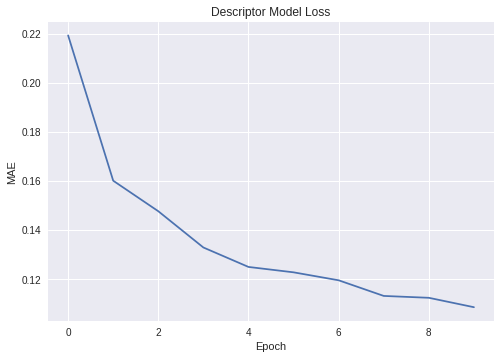

In [10]:
import matplotlib.pyplot as plt

print(descriptor_history.history.keys())
plt.plot(descriptor_history.history['loss'])
plt.title('Descriptor Model Loss')
plt.ylabel('MAE')
plt.xlabel('Epoch')

Evaluation of the

In [0]:
generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model, use_clean=False)

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval

100%|██████████| 40/40 [06:29<00:00, 11.57s/it]



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
Processing verification task 1/3 : 100% 1000000/1000000 [01:24<00:00, 11772.41it/s]
Processing verification task 2/3 : 100% 1000000/1000000 [01:24<00:00, 11864.20it/s]
Processing verification task 3/3 : 100% 1000000/1000000 [01:25<00:00, 11695.26it/s]
>> Verification task finished in 263 secs  
Verification task results:
Mean Average Precision is 0.784983



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
100% 40/40 [02:12<00:00,  4.49s/it]
>> Matching task finished in 132 secs  
Matching task results:
Mean Average Precision is 0.187820





>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
tcmalloc: large a